NDB Model

**Sources**:
- [Illustrating the Performance of the NBD as a Benchmark Model for Customer-Base Analysis](http://www.brucehardie.com/notes/005/)
- ["Counting Your Customers" the Easy Way: An Alternative to the Pareto/NBD Model](https://brucehardie.com/papers/018/)
- [A Note on Implementing the Pareto/NBD Model in MATLAB](https://www.brucehardie.com/notes/008/)
- 

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import beta, gamma, gammaln, factorial, hyp2f1
from scipy.stats import chisquare, chi2

import polars as pl
import matplotlib.pyplot as plt
import matplotlib_inline
from IPython.display import display_markdown

from utils import CDNOW, bic

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [2]:
data = (
    CDNOW(master=False, calib_p=273)
    .rfm_summary()
    .select('P1X', 't_x', 'T')
)

# x: 'repeat_trans' = “repeat frequency”, number of repeat transactions made by a customer in a specified time period.
# t_x: 'last_purch' (in weeks) = Time of last calibration period repeat purchase 
# T: 'T' (in weeks) = length of time over which we have had an opportunity to observe any repeat purchasing behavior. 
# 'first_purch' = Time of first purchase (in weeks)
repeat_trans, last_purch, T = np.hsplit(data.collect().to_numpy(), 3)
num_customers = len(repeat_trans)

In [3]:
# NBD Model - timing-model equivalent of the basic NBD model
def nbd_timing_params(x, T):
    def log_likelihood(params):
        r, alpha = params
        return -np.sum(gammaln(r+x)-gammaln(r)+r*np.log(alpha)-(r+x)*np.log(alpha+T))
    return minimize(log_likelihood, x0=[0.1,0.1], bounds=[(1e-6, np.inf), (1e-6, np.inf)])

def nbd_pmf(x, t, r, alpha):
    # P(X(T)=x)
    # np.exp(gammaln(r+x)-gammaln(r))/factorial(x) * (alpha/(alpha+t))**r * (t/(alpha+t))**x
    return gamma(r + x)/(gamma(r)*factorial(x)) * (alpha/(alpha+t))**r * (t/(alpha+t))**x

# For a randomly-chosen individual, the expected number of transactions in a time period of length t is given by the mean of the NBD
def nbd_E_X_t(t, r, alpha):
    return r/alpha * t

def nbd_E_Y_X(x, T, t, r, alpha):
    return (r+x)/(alpha+T) * t

# NBD Model - standard counting form
def nbd_params(x, T):
    def log_likelihood(params):
        r, alpha = params
        pmf = nbd_pmf(x, T, r, alpha)
        return -np.sum(np.log(pmf))
    return minimize(log_likelihood, x0=[0.1,0.1], bounds=[(1e-6, np.inf), (1e-6, np.inf)])

# BG/NBD Model
def bgnbd_params(x, t_x, T):
    def log_likelihood(params):
        r, alpha, a, b = params
        likelihood_function = (
            beta(a,b+x)/beta(a,b) * 
            (gamma(r+x)*alpha**r)/(gamma(r)*(alpha+T)**(r+x))
        )
        likelihood_function += (
            np.where(x > 0,
                beta(a+1, b+x-1)/beta(a,b) *
                (gamma(r+x)*alpha**r)/(gamma(r)*(alpha+t_x)**(r+x)),
                0)
        )
        return -np.sum(np.log(likelihood_function))
    
    bnds = [(1e-6, np.inf) for _ in range(4)]
    guess = [0.01 for _ in range(4)]
    return minimize(log_likelihood, x0=guess, bounds=bnds)

# expected number of purchases in a time period of length t
def bgnbd_E_X_t(t, r, alpha, a, b):
    return (a+b-1)/(a-1) * (1 - (alpha/(alpha+t))**r * hyp2f1(r, b, a+b-1, t/(alpha+t)))

# probability of observing x purchases in a time period of length t
def bgnbd_pmf(f_x, t, r, alpha, a, b):
    A = np.cumsum(
        gamma(r+f_x[:-1])/(gamma(r)*factorial(f_x[:-1])) *
        (t/(alpha+t))**f_x[:-1], axis=0
    )
    pmf = (
        beta(a,b+f_x)/beta(a,b) * 
        gamma(r+f_x)/(gamma(r)*factorial(f_x)) * 
        (alpha/(alpha+t))**r * 
        (t/(alpha+t))**f_x
    )
    pmf[1:] += (
        beta(a+1,b+f_x[1:]-1)/beta(a,b) *
        (1 - (alpha/(alpha+t))**r * A)        
    )
    return pmf

def bgnbd_E_Y_X(x, t_x, T, t, r, alpha, a, b):
    h2f1_cust = hyp2f1(r+x, b+x, a+b+x-1, t/(alpha + T + t))
    return (
        (a + b + x - 1) / (a - 1) * (1 - ((alpha + T) / (alpha + T + t))**(r + x) * h2f1_cust) /
        (1 + (x > 0) * a / (b + x - 1) * ((alpha + T) / (alpha + t_x))**(r + x))
    )

# Pareto/NBD Model
def paretonbd_params(x, t_x, T):
    
    def log_likelihood(params):
        r, alpha, s, beta = params
        
        maxab = np.max((alpha, beta))
        absab = np.abs(alpha - beta)
        param2 = s + 1
        if alpha < beta:
            param2 = r + x
            
        part1 = (alpha**r * beta**s / gamma(r)) * gamma(r+x)
        part2 = 1/((alpha+T)**(r+x) * (beta+T)**s)

        if absab == 0:
            F1 = 1/((maxab+t_x)**(r+s+x))
            F2 = 1/((maxab+T)**(r+s+x))
        else:
            F1 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+t_x)) / ((maxab+t_x)**(r+s+x))
            F2 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+T)) / ((maxab+T)**(r+s+x))        
        
        return -np.sum(np.log(part1*(part2+(s/(r+s+x))*(F1-F2))))
    
    bnds = [(1e-6, 20) for _ in range(4)]
    guess = [0.01 for _ in range(4)]
    return minimize(log_likelihood, x0=guess, bounds=bnds)

# distribution of the number of transactions in the interval (0, t] for a randomly-chosen individual
def paretonbd_pmf(f_x, t, r, alpha, s, beta_param):
    maxab = np.max((alpha, beta_param))
    absab = np.abs(alpha - beta_param)
    param2 = s + 1
    if alpha < beta_param:
        param2 = r + f_x    
    B2i = np.cumsum(
        gamma(r+s+f_x)/gamma(r+s) * t**f_x / factorial(f_x) *
        hyp2f1(r+s+f_x, param2, r+s+f_x+1, absab/(maxab+t)) / 
        (maxab+t)**(r+s+f_x),
        axis=0
    )
    pmf = (
        gamma(r+f_x)/(gamma(r)*factorial(f_x)) *
        (alpha/(alpha+t))**r * 
        (t/(alpha+t))**f_x *
        (beta_param/(beta_param+t))**s +
        alpha**r * beta_param**s *
        beta(r+f_x,s+1)/beta(r,s) *
        (hyp2f1(r+s, param2, r+s+f_x+1, absab/maxab) / maxab**(r+s) - B2i)
    )
    return pmf

def paretonbd_E_X_t(t, r, alpha, s, beta_param):
    return r*beta_param/(alpha*(s-1)) * (1 - (beta_param/(beta_param + t))**(s-1))

def paretonbd_pactive(x, t_x, T, r, alpha, s, beta_param):
    maxab = np.max((alpha, beta_param))
    absab = np.abs(alpha - beta_param)
    param2 = s + 1
    if alpha < beta_param:
        param2 = r + x

    F0 = (alpha + T)**(r + x) * (beta_param + T)**s

    if absab == 0:
        F1 = 1/((maxab+t_x)**(r+s+x))
        F2 = 1/((maxab+T)**(r+s+x))
    else:
        F1 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+t_x)) / ((maxab+t_x)**(r+s+x))
        F2 = hyp2f1(r+s+x, param2, r+s+x+1, absab/(maxab+T)) / ((maxab+T)**(r+s+x))       

    return (1 + (s / (r+s+x)) * F0 * (F1-F2))**(-1)

def paretonbd_E_Y_X(x, t_x, T, t, r, alpha, s, beta_param):
    return (
        (r + x) * (beta_param + T) / ((alpha + T) * (s - 1)) *
        (1 - ((beta_param + T) / (beta_param + T + t))**(s - 1)) *
        paretonbd_pactive(x, t_x, T, r, alpha, s, beta_param)
    )

In [4]:
res = nbd_timing_params(repeat_trans, T)
r_nbd, alpha_nbd = res.x
ll = res.fun

display_markdown(f'''**NBD - Timing-Model Equivalent:**

Parameter Estimates:
- $r$ = {r_nbd:0.4f}
- $\\alpha$ = {alpha_nbd:0.4f}

Log-Likelihood = {-ll:0.4f}

BIC = {bic(2, num_customers, ll):.1f}''', raw=True)

res = nbd_params(repeat_trans, T)
r, alpha = res.x
ll = res.fun

display_markdown(f'''**NBD - Standard Counting Method:**

Parameter Estimates:
- $r$ = {r:0.4f}
- $\\alpha$ = {alpha:0.4f}

Log-Likelihood = {-ll:0.4f}

BIC = {bic(2, num_customers, ll):.1f}''', raw=True)

res = bgnbd_params(repeat_trans, last_purch, T)
r_bgnbd, alpha_bgnbd, a_bgnbd, b_bgnbd = res.x
ll = res.fun

display_markdown(f'''**BG/NBD:**

Parameter Estimates:
- $r$ = {r_bgnbd:0.4f}
- $\\alpha$ = {alpha_bgnbd:0.4f}
- $a$ = {a_bgnbd:0.4f}
- $b$ = {b_bgnbd:0.4f}

Log-Likelihood = {-ll:0.4f}

BIC = {bic(4, num_customers, ll):.1f}''', raw=True)

res = paretonbd_params(repeat_trans, last_purch, T)
r_pareto, alpha_pareto, s, beta_param = res.x
ll = res.fun

display_markdown(f'''**Pareto/NBD:**

Parameter Estimates:
- $r$ = {r_pareto:0.4f}
- $\\alpha$ = {alpha_pareto:0.4f}
- $s$ = {s:0.4f}
- $\\beta$ = {beta_param:0.4f}

Log-Likelihood = {-ll:0.4f}

BIC = {bic(4, num_customers, ll):.1f}''', raw=True)

**NBD - Timing-Model Equivalent:**

Parameter Estimates:
- $r$ = 0.3848
- $\alpha$ = 12.0718

Log-Likelihood = -9763.6576

BIC = 19542.8

**NBD - Standard Counting Method:**

Parameter Estimates:
- $r$ = 0.3848
- $\alpha$ = 12.0718

Log-Likelihood = -3193.0587

BIC = 6401.6

**BG/NBD:**

Parameter Estimates:
- $r$ = 0.2426
- $\alpha$ = 4.4136
- $a$ = 0.7929
- $b$ = 2.4258

Log-Likelihood = -9582.4292

BIC = 19195.9

**Pareto/NBD:**

Parameter Estimates:
- $r$ = 0.5533
- $\alpha$ = 10.5781
- $s$ = 0.6064
- $\beta$ = 11.6726

Log-Likelihood = -9594.9762

BIC = 19221.0

Predicted Distribution of Transactions

In [5]:
def nbd_predict_trans_dist(f_x, n_s, T, r, alpha):
    '''
    Parameters:
    f_x:    frequency of repeat transactions (right-censored)
    n_s:    the number of customers who made their first purchase on day s
    T:      the number of days (in weeks) during which repeat transactions could have occurred in the calibration period, 
            it follows that the “time of first purchase” is simply: calibration week - T.
            T = t - s/7 (in weeks), T = effective calibration period, s = time of trial purchase, t = duration of calibration period 
    r, alpha: NBD model parameters
    '''
    pmf = nbd_pmf(f_x, T, r, alpha)
    pmf[-1] = 1 - np.sum(pmf[:-1], axis=0)
    return np.dot(pmf, n_s)

def bgnbd_predict_trans_dist(f_x, n_s, T, r, alpha, a, b):
    pmf = bgnbd_pmf(f_x, T, r, alpha, a, b)
    pmf[-1] = 1 - np.sum(pmf[:-1], axis=0)
    return np.dot(pmf, n_s)

def paretonbd_redict_trans_dist(f_x, n_s, t, r, alpha, s, beta_param):
    pmf = paretonbd_pmf(f_x, t, r, alpha, s, beta_param)
    pmf[-1] = 1 - np.sum(pmf[:-1], axis=0)
    return np.dot(pmf, n_s)

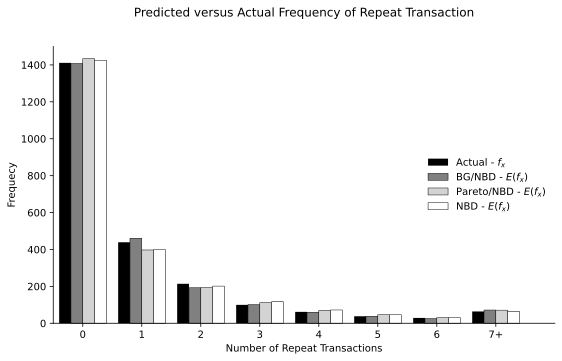

In [6]:
num_repeats, repeat_freq = np.unique(repeat_trans, return_counts=True)

# right-censored distribution in which counts greater than 7 are collapsed into a 7+ bin
num_repeats_censored = num_repeats[:8].copy()
repeat_freq_censored = repeat_freq[:8].copy()
repeat_freq_censored[-1] = np.sum(repeat_freq) - np.sum(repeat_freq[:7])

# n_s is the number of customers who made their first purchase on day s
# T_unique is the unique t - s/7 weeks within which to make repeat purchases
T_unique, n_s = np.unique(T, return_counts=True)

nbd_E_f_x = nbd_predict_trans_dist(num_repeats_censored.reshape(-1,1), n_s, T_unique, r_nbd, alpha_nbd)
bgnbd_E_f_x = bgnbd_predict_trans_dist(num_repeats_censored.reshape(-1,1), n_s, T_unique, r_bgnbd, alpha_bgnbd, a_bgnbd, b_bgnbd)
paretonbd_E_f_x = paretonbd_redict_trans_dist(num_repeats_censored.reshape(-1,1), n_s, T_unique, r_pareto, alpha_pareto, s, beta_param)

bar_width = 0.2
plt.figure(figsize=(9,5), dpi=100)
plt.bar(num_repeats_censored - bar_width*1.5, repeat_freq_censored, width=bar_width, label='Actual - $f_x$', color='black')
plt.bar(num_repeats_censored - bar_width/2, bgnbd_E_f_x, width=bar_width, label='BG/NBD - $E(f_x)$', color='grey', edgecolor='black', linewidth=0.5)
plt.bar(num_repeats_censored + bar_width/2, paretonbd_E_f_x, width=bar_width, label='Pareto/NBD - $E(f_x)$', color='lightgrey', edgecolor='black', linewidth=0.5)
plt.bar(num_repeats_censored + bar_width*1.5, nbd_E_f_x, width=bar_width, label='NBD - $E(f_x)$', color='white', edgecolor='black', linewidth=0.5)
plt.xlabel("Number of Repeat Transactions")
plt.ylabel("Frequecy")
plt.title('Predicted versus Actual Frequency of Repeat Transaction', pad=30)
plt.xticks(num_repeats_censored, [0,1,2,3,4,5,6,'7+'])
plt.ylim(0, 1500)
plt.xlim(0-bar_width*2.5, 8)
plt.legend(loc=7, frameon=False);

In [7]:
test_stat_nbd, p_value_nbd = chisquare(repeat_freq_censored, nbd_E_f_x, ddof=2)
critical_val_nbd = chi2.isf(0.05, df=5)

test_stat_bgnbd, p_value_bgnbd = chisquare(repeat_freq_censored, bgnbd_E_f_x, ddof=4)
critical_val_bgnbd = chi2.isf(0.05, df=3)

test_stat_paretonbd, p_value_paretonbd = chisquare(repeat_freq_censored, paretonbd_E_f_x, ddof=4)
critical_val_paretonbd = chi2.isf(0.05, df=3)

display_markdown(f'''**NBD:**

- Test Statistics = {test_stat_nbd:.2f}
- df = {5}
- Critical Value = {critical_val_nbd:.3f}
- p-Value = {p_value_nbd:.3f}

**BG/NBD:**

- Test Statistics = {test_stat_bgnbd:.2f}
- df = {3}
- Critical Value = {critical_val_bgnbd:.3f}
- p-Value = {p_value_bgnbd:.3f}

**Pareto/NBD:**

- Test Statistics = {test_stat_paretonbd:.2f}
- df = {3}
- Critical Value = {critical_val_paretonbd:.3f}
- p-Value = {p_value_paretonbd:.3f}''', raw=True)

**NBD:**

- Test Statistics = 10.27
- df = 5
- Critical Value = 11.070
- p-Value = 0.068

**BG/NBD:**

- Test Statistics = 4.82
- df = 3
- Critical Value = 7.815
- p-Value = 0.185

**Pareto/NBD:**

- Test Statistics = 11.56
- df = 3
- Critical Value = 7.815
- p-Value = 0.009

Aggregate Sales Forecast

In [8]:
def nbd_cum_repeat_trans(n_s, s, t, r, alpha, period=7):
    '''
    Parameters:
    n_s:    the number of customers who made their first purchase on day s
    s:      range of time of trial purchase (in weeks if 'period' = 7)
    t:      range of the forecast horizon (in weeks if 'period' = 7)
    r, alpha: NBD model parameters    
    period: 7 = weekly
    '''
    nbd_mean = nbd_E_X_t(t.reshape(-1,1)-s, r, alpha)
    nbd_mean = np.where(nbd_mean > 0, nbd_mean, 0)
    cum_rpt_sales = np.dot(nbd_mean, n_s)
    return cum_rpt_sales[period-1::period]

def bgnbd_cum_repeat_trans(n_s, s, t, r, alpha, a, b, period=7):
    E_X_t = bgnbd_E_X_t(t, r, alpha, a, b)
    s = np.arange(np.max(s)*period - 1, -1, -1, dtype=np.int32)
    t = np.arange(np.max(t)*period, dtype=np.int32).reshape(-1,1)
    index = np.clip(t - s, 0, len(E_X_t))
    E_X_t = np.where(t > s, E_X_t[index-1], 0)
    return np.dot(E_X_t, n_s)[6::7]

def paretonbd_cum_repeat_trans(n_s, s, t, r, alpha, s_param, beta_param, period=7):
    E_X_t = paretonbd_E_X_t(t, r, alpha, s_param, beta_param)
    s = np.arange(np.max(s)*period - 1, -1, -1, dtype=np.int32)
    t = np.arange(np.max(t)*period, dtype=np.int32).reshape(-1,1)
    index = np.clip(t - s, 0, len(E_X_t))
    E_X_t = np.where(t > s, E_X_t[index-1], 0)
    return np.dot(E_X_t, n_s)[6::7]

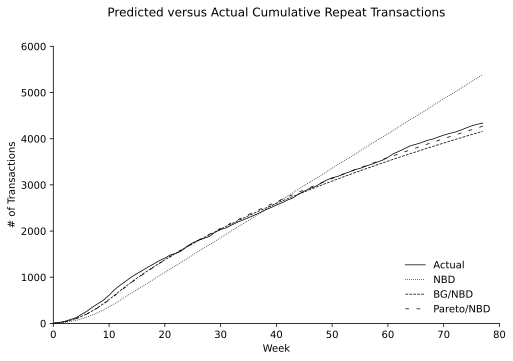

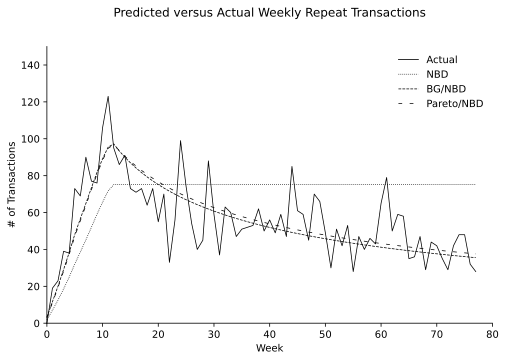

In [9]:
actual_cum_repeat, actual_wkly_sales, actual_cum_repeat = np.hsplit(CDNOW(master=False, calib_p=273).repeat_sales().to_numpy(), 3)

forecast_horizon = np.arange(1/7, 78, 1/7) # day-by-day in weeks
calib_p = 39 # in weeks

nbd_cum_repeat = nbd_cum_repeat_trans(n_s, calib_p-T_unique, forecast_horizon, r_nbd, alpha_nbd)
nbd_wkly_repeat = np.diff(nbd_cum_repeat, prepend=0)

bgnbd_cum_repeat = bgnbd_cum_repeat_trans(n_s, calib_p-T_unique, forecast_horizon, r_bgnbd, alpha_bgnbd, a_bgnbd, b_bgnbd)
bgnbd_wkly_repeat = np.diff(bgnbd_cum_repeat, prepend=0)

paretonbd_cum_repeat = paretonbd_cum_repeat_trans(n_s, calib_p-T_unique, forecast_horizon, r_pareto, alpha_pareto, s, beta_param)
paretonbd_wkly_repeat = np.diff(paretonbd_cum_repeat, prepend=0)

forecast_horizon = np.arange(78)
plt.figure(figsize=(8,5), dpi=100)
plt.plot(forecast_horizon, actual_cum_repeat, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.plot(forecast_horizon, nbd_cum_repeat, color='black', linestyle='dotted', linewidth=0.75, label='NBD')
plt.plot(forecast_horizon, bgnbd_cum_repeat, color='black', linestyle='dashed', linewidth=0.75, label='BG/NBD')
plt.plot(forecast_horizon, paretonbd_cum_repeat, color='black', linestyle=(0, (5, 10)), linewidth=0.75, label='Pareto/NBD')
plt.xlabel("Week")
plt.ylabel("# of Transactions")
plt.title('Predicted versus Actual Cumulative Repeat Transactions', pad=30)
plt.ylim(0,6000)
plt.xlim(0, 80)
plt.legend(loc=4, frameon=False);

plt.figure(figsize=(8,5), dpi=100)
plt.plot(forecast_horizon, actual_wkly_sales, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.plot(forecast_horizon, nbd_wkly_repeat, color='black', linestyle='dotted', linewidth=0.75, label='NBD')
plt.plot(forecast_horizon, bgnbd_wkly_repeat, color='black', linestyle='dashed', linewidth=0.75, label='BG/NBD')
plt.plot(forecast_horizon, paretonbd_wkly_repeat, color='black', linestyle=(0, (5, 10)), linewidth=0.75, label='Pareto/NBD')
plt.xlabel("Week")
plt.ylabel("# of Transactions")
plt.title('Predicted versus Actual Weekly Repeat Transactions', pad=30)
plt.ylim(0,150)
plt.xlim(0, 80)
plt.legend(loc=1, frameon=False);

Conditional Expectations

In [10]:
actual_ce = (
    CDNOW(master=False, calib_p=273)
    .rfm_summary()
    .group_by('P1X').agg(pl.col('P2X').mean().alias('Actual CE'))
    .sort('P1X').select('Actual CE')
)

t = 39 # the length of the period over which we wish to make the conditional forecast
nbd_ce = nbd_E_Y_X(repeat_trans, T, t, r_nbd, alpha_nbd)
bgnbd_ce = bgnbd_E_Y_X(repeat_trans, last_purch, T, t, r_bgnbd, alpha_bgnbd, a_bgnbd, b_bgnbd)
paretonbd_ce = paretonbd_E_Y_X(repeat_trans, last_purch, T, t, r_pareto, alpha_pareto, s, beta_param)

nbd_ce, bgnbd_ce, paretonbd_ce, actual_ce  =  np.hsplit(
    pl.DataFrame({'x': repeat_trans.astype(np.int32).flatten(), 
                  'NBD - E(Y|X)': nbd_ce.flatten(),
                  'BG/NBD - E(Y|X)': bgnbd_ce.flatten(),
                  'Pareto/NBD -  E(Y|X)': paretonbd_ce.flatten()})
    .group_by('x')
    .agg(pl.col('NBD - E(Y|X)', 'BG/NBD - E(Y|X)', 'Pareto/NBD -  E(Y|X)').mean())
    .sort('x').hstack(actual_ce.collect()).drop('x').to_numpy(), 4
)

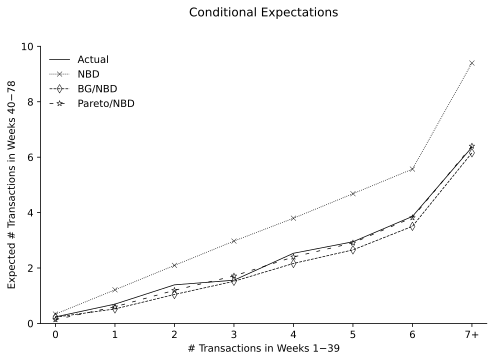

In [11]:
censor = 7

actual_ce_censored = actual_ce[:censor+1].copy()
actual_ce_censored[-1] = np.dot(repeat_freq[censor:], actual_ce[censor:]) / np.sum(repeat_freq[censor:])

nbd_ce_censored = nbd_ce[:censor+1].copy()
nbd_ce_censored[-1] = np.dot(repeat_freq[censor:], nbd_ce[censor:]) / np.sum(repeat_freq[censor:])

bgnbd_ce_censored = bgnbd_ce[:censor+1].copy()
bgnbd_ce_censored[-1] = np.dot(repeat_freq[censor:], bgnbd_ce[censor:]) / np.sum(repeat_freq[censor:])

paretonbd_ce_censored = paretonbd_ce[:censor+1].copy()
paretonbd_ce_censored[-1] = np.dot(repeat_freq[censor:], paretonbd_ce[censor:]) / np.sum(repeat_freq[censor:])

plt.figure(figsize=(8,5), dpi=100)
plt.plot(num_repeats_censored, actual_ce_censored, color='black', linestyle='solid', linewidth=0.75, label='Actual')
plt.plot(num_repeats_censored, nbd_ce_censored, color='black', linestyle='dotted', marker='x', markersize=5, markeredgewidth=0.4, linewidth=0.75, label='NBD')
plt.plot(num_repeats_censored, bgnbd_ce_censored, color='black', linestyle='dashed', marker='d', fillstyle='none', markeredgewidth=0.5, linewidth=0.75, label='BG/NBD')
plt.plot(num_repeats_censored, paretonbd_ce_censored, color='black', linestyle=(0, (5, 10)), marker='*', fillstyle='none', markeredgewidth=0.5, linewidth=0.75, label='Pareto/NBD')
plt.xlabel("# Transactions in Weeks 1−39")
plt.ylabel("Expected # Transactions in Weeks 40−78")
plt.title('Conditional Expectations', pad=30)
plt.xticks(num_repeats_censored, [0,1,2,3,4,5,6,'7+'])
plt.ylim(0,10)
plt.xlim(-0.25, 7.25)
plt.legend(loc=2, frameon=False);   